In [1]:
# =============================================================================
# IMPORTS & SETTINGS
# =============================================================================
import os
import random
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

import catboost as ctb
import lightgbm as lgb
import xgboost as xgb

import tensorflow as tf
import keras
from keras import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras import Model as keras_model
from tensorflow.keras.layers import (
    Embedding, Concatenate, Flatten, Dropout, BatchNormalization
)

from sklearn.model_selection import (
    StratifiedKFold, KFold, train_test_split, RepeatedStratifiedKFold
)
from sklearn.metrics import (
    cohen_kappa_score, mean_squared_error
)
from sklearn.preprocessing import (
    LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
)
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression, Lasso
from sklearn.ensemble import (
    HistGradientBoostingClassifier, RandomForestClassifier
)
from keras.utils import set_random_seed

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# =============================================================================
# SEED & WARNINGS
# =============================================================================
RND_SEED = 42
warnings.filterwarnings('ignore')
random.seed(RND_SEED)
np.random.seed(RND_SEED)
tf.random.set_seed(RND_SEED)
set_random_seed(RND_SEED)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(RND_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.experimental.enable_op_determinism() 

In [2]:
# =============================================================================
# DATA READING
# =============================================================================
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

In [3]:
# Shape and head
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
display(train.head())

# Info and data types
train.info()

# Target stats
target_col = 'PCIAT-PCIAT_Total'
print("\nTarget variable stats:")
display(train[target_col].describe())

# Check for duplicates
print("\nDuplicate rows:", train.duplicated().sum())

Train shape: (3960, 82)
Test shape: (20, 59)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

count    2736.000000
mean       27.896199
std        20.338853
min         0.000000
25%        12.000000
50%        26.000000
75%        41.000000
max        93.000000
Name: PCIAT-PCIAT_Total, dtype: float64


Duplicate rows: 0


,Missing Count,Missing %
PAQ_A-PAQ_A_Total,3485,88.005051
PAQ_A-Season,3485,88.005051
Fitness_Endurance-Time_Mins,3220,81.313131
Fitness_Endurance-Time_Sec,3220,81.313131
Fitness_Endurance-Max_Stage,3217,81.237374
...,...,...
Physical-Weight,884,22.323232
PreInt_EduHx-computerinternet_hoursday,659,16.641414
Physical-Season,650,16.414141
FGC-Season,614,15.505051


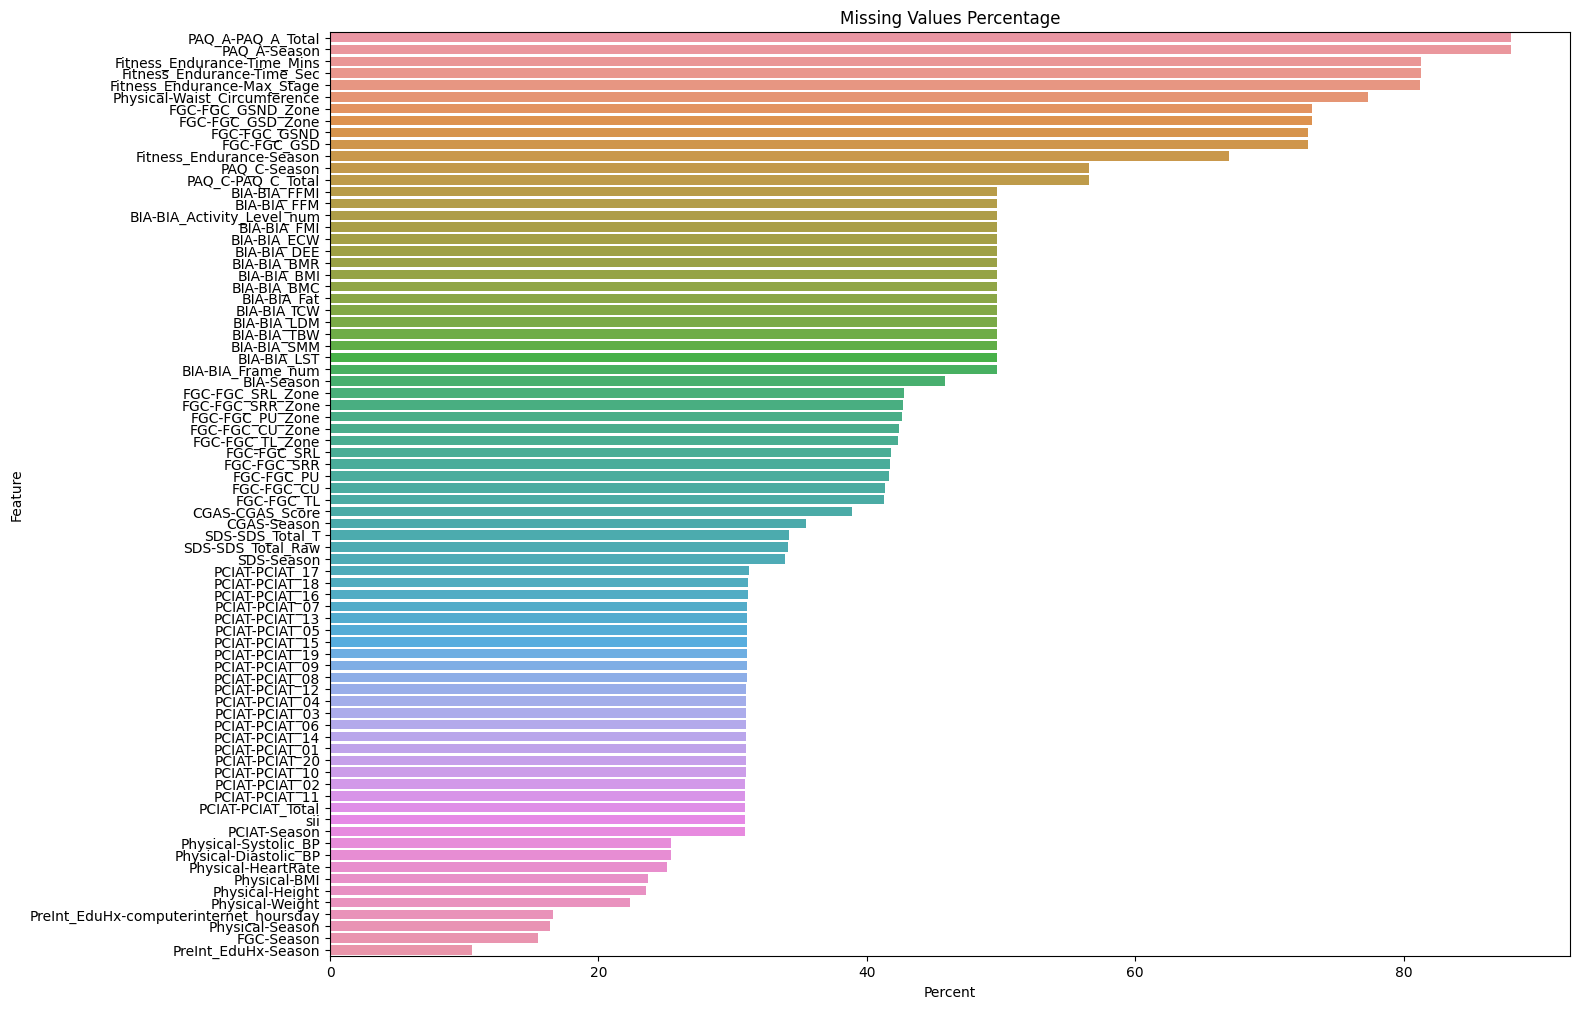

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Total and percentage of missing values
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_percent = (missing / len(train)) * 100

# Combine into a DataFrame
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
display(missing_df)

# Barplot of missing percentages
plt.figure(figsize=(16, 12))
sns.barplot(x=missing_percent.values, y=missing_percent.index)
plt.title("Missing Values Percentage")
plt.xlabel("Percent")
plt.ylabel("Feature")
plt.show()


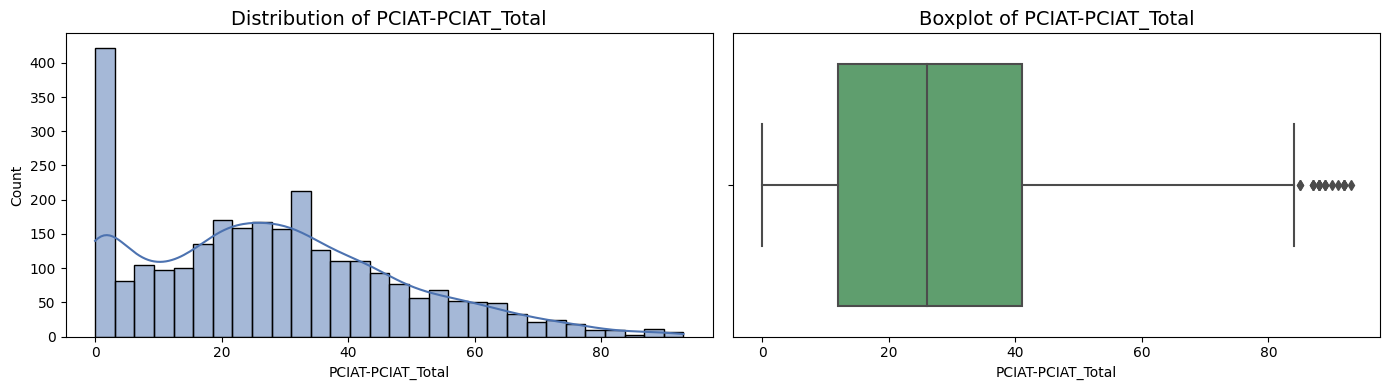

In [5]:
plt.figure(figsize=(14, 4))

# Histogram + KDE
plt.subplot(1, 2, 1)
sns.histplot(train['PCIAT-PCIAT_Total'], bins=30, kde=True, color="#4C72B0")
plt.title("Distribution of PCIAT-PCIAT_Total", fontsize=14)
plt.xlabel("PCIAT-PCIAT_Total")
plt.ylabel("Count")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=train['PCIAT-PCIAT_Total'], color="#55A868")
plt.title("Boxplot of PCIAT-PCIAT_Total", fontsize=14)
plt.xlabel("PCIAT-PCIAT_Total")

plt.tight_layout()
plt.show()

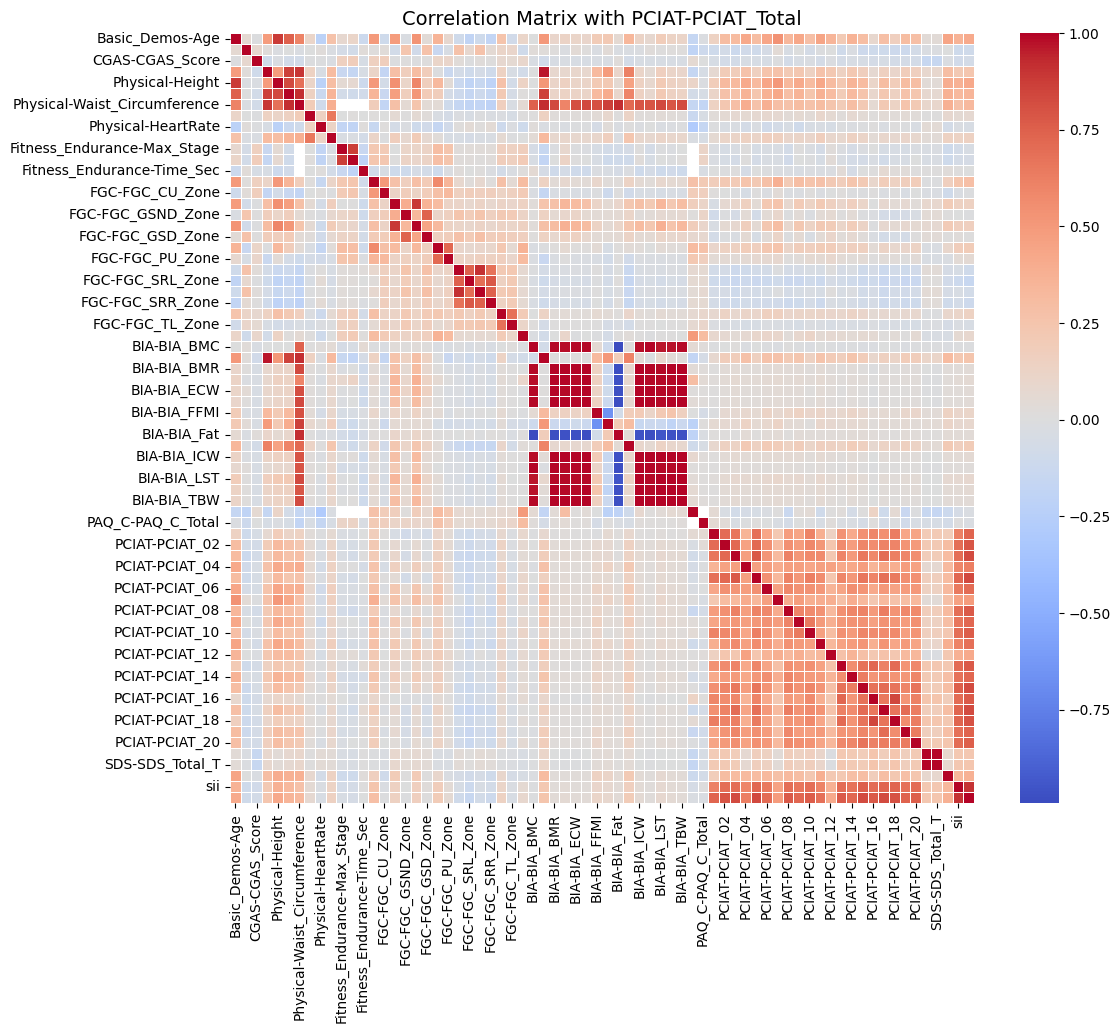

In [6]:
# Select numerical columns
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = [col for col in num_cols if col not in ['PCIAT-PCIAT_Total']]  # exclude target

# Basic stats
train[num_cols].describe().T

# Correlation matrix (with target)
corr = train[num_cols + ['PCIAT-PCIAT_Total']].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix with PCIAT-PCIAT_Total", fontsize=14)
plt.show()

Top 5 features correlated with target: ['sii', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_03']


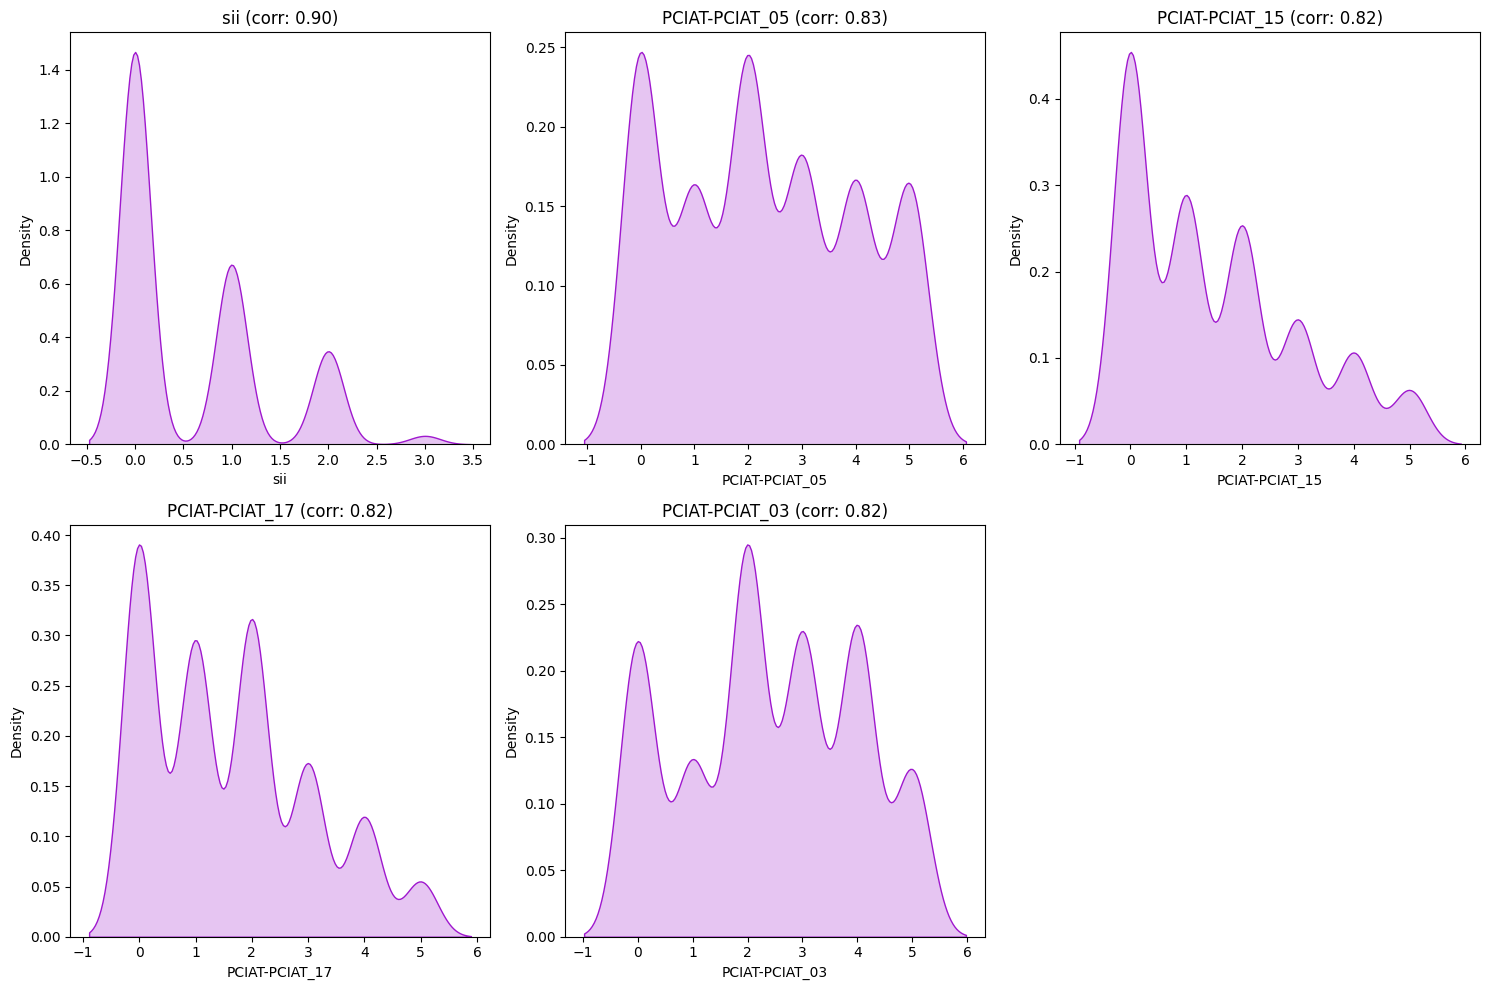

In [7]:
# Get top 5 correlated features with the target
top_corr = corr['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total').abs().sort_values(ascending=False).head(5).index.tolist()
print("Top 5 features correlated with target:", top_corr)

# Plot their distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(top_corr):
    plt.subplot(2, 3, i + 1)
    sns.kdeplot(train[col], fill=True, color="#9F18CE")
    plt.title(f"{col} (corr: {corr[col]['PCIAT-PCIAT_Total']:.2f})")
    plt.xlabel(col)
plt.tight_layout()
plt.show()

Categorical columns: ['id', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season']


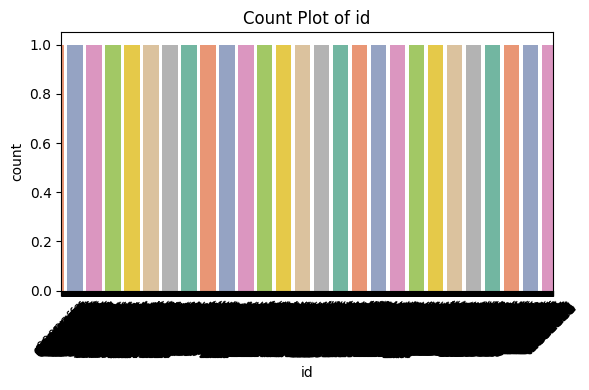

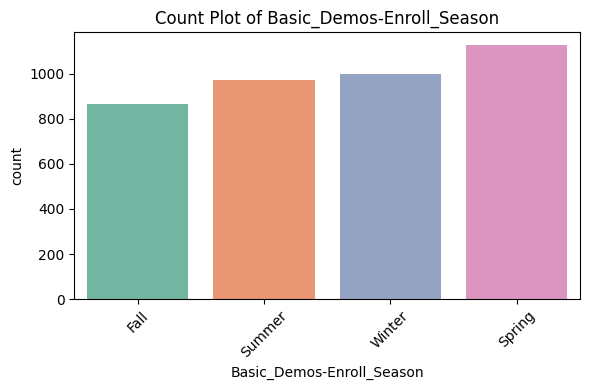

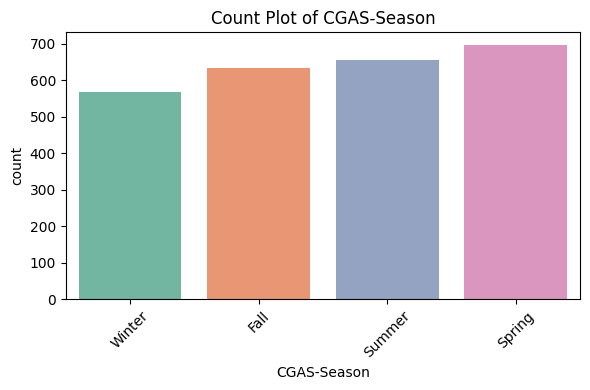

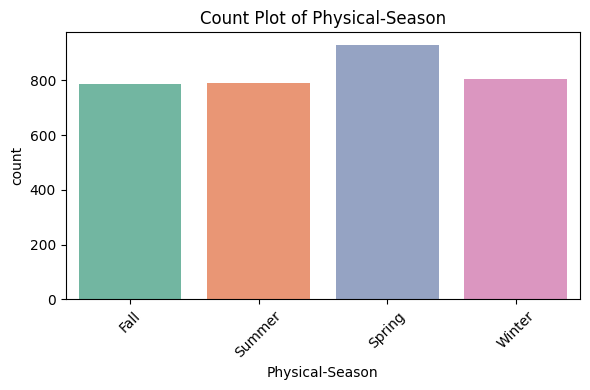

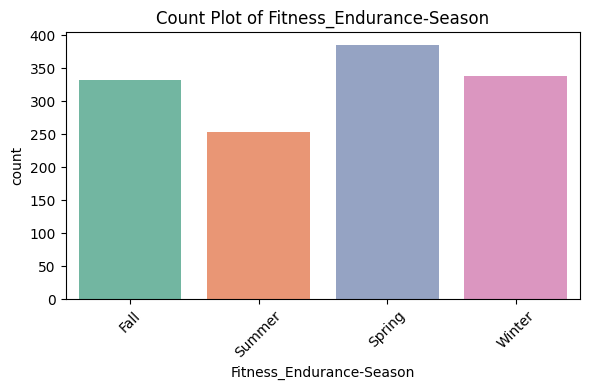

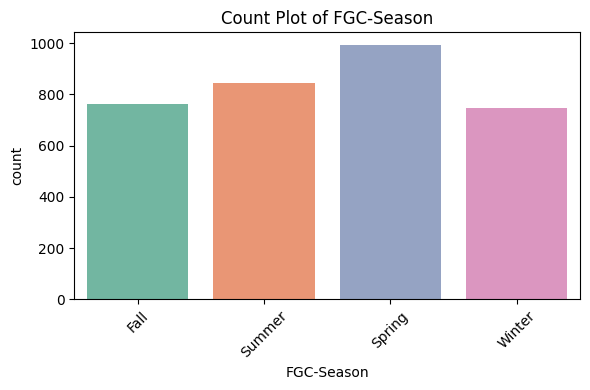

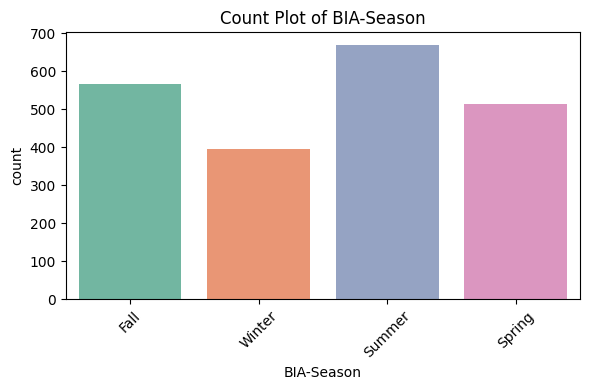

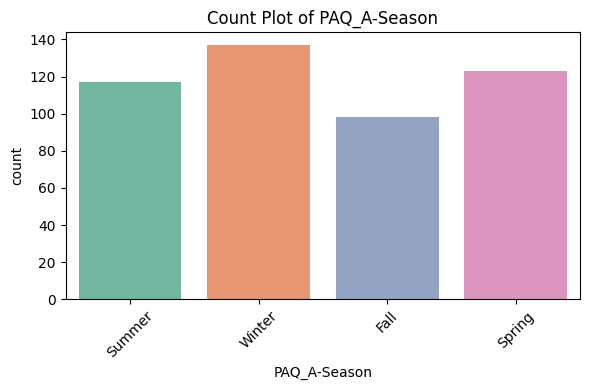

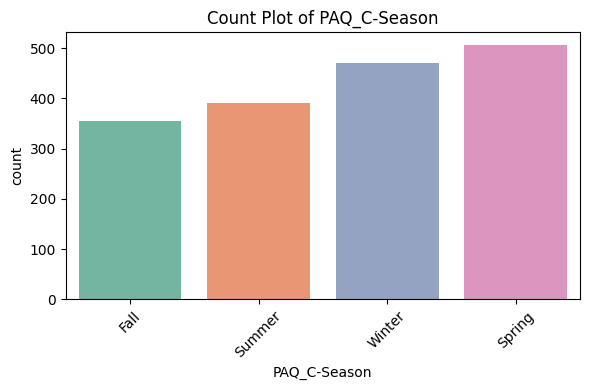

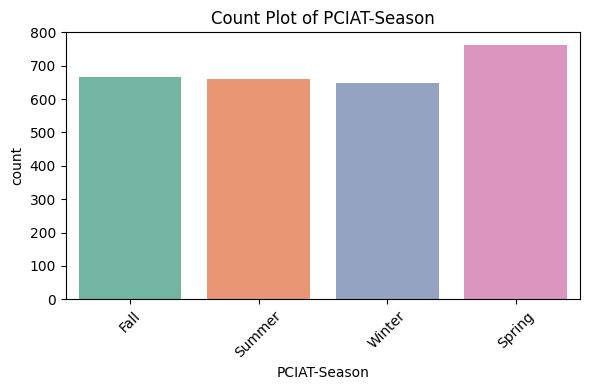

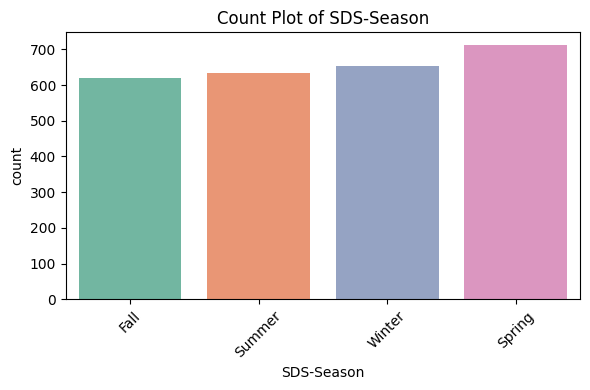

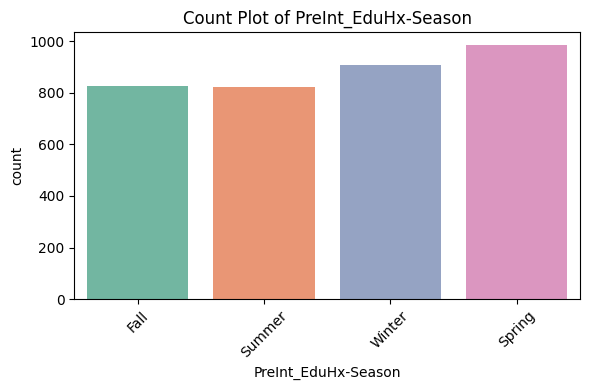

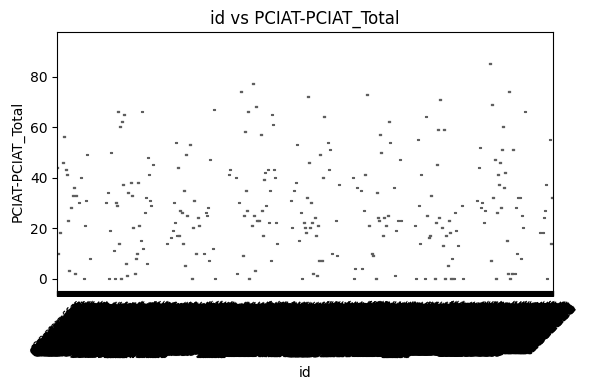

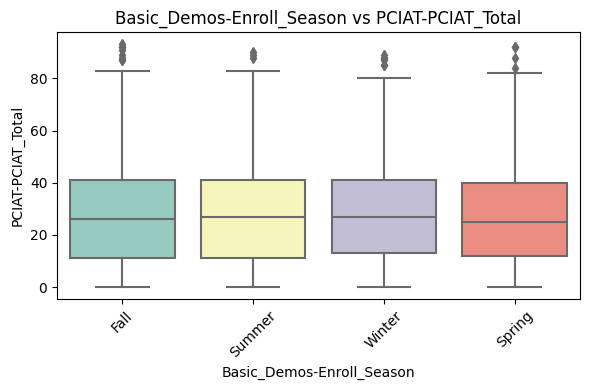

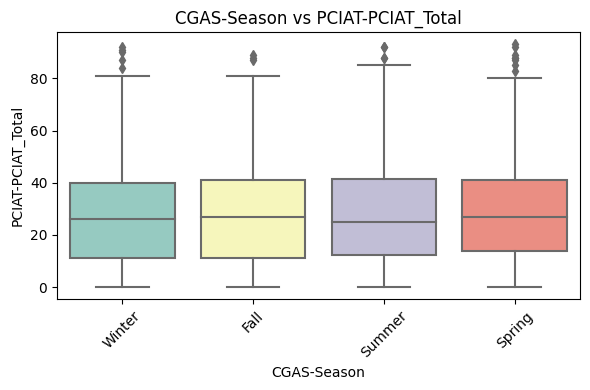

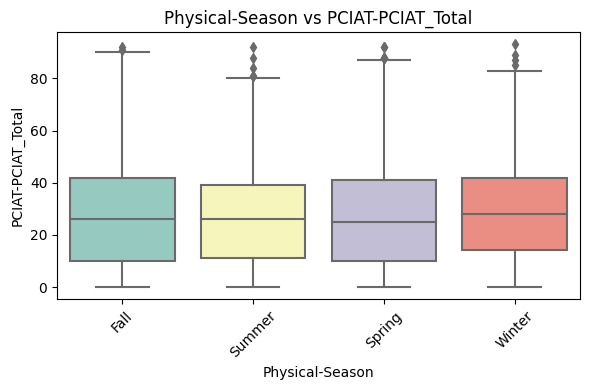

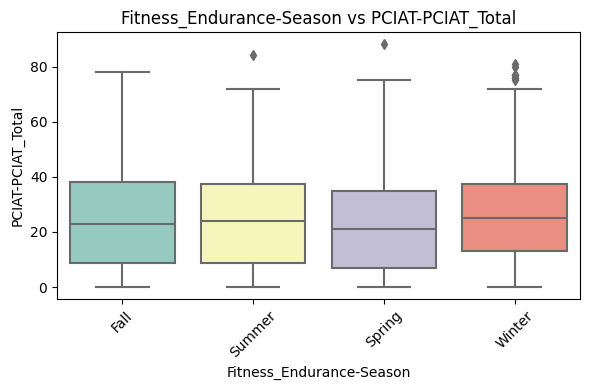

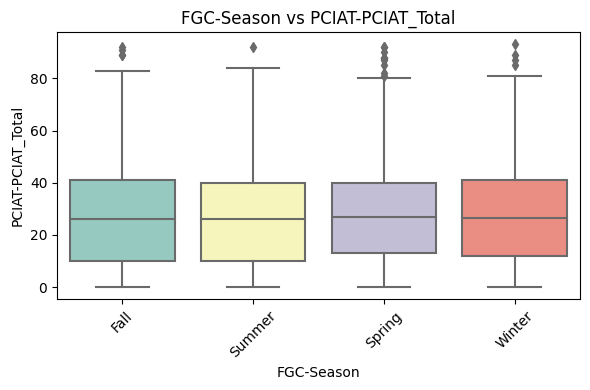

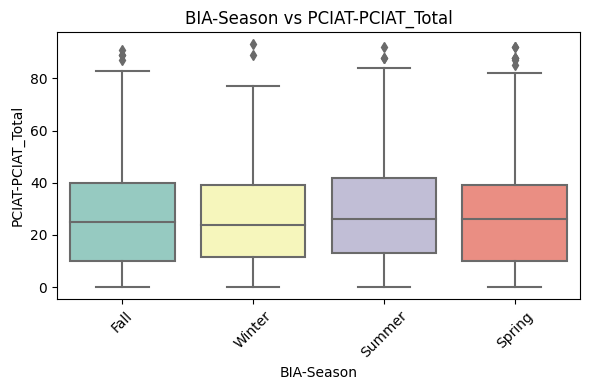

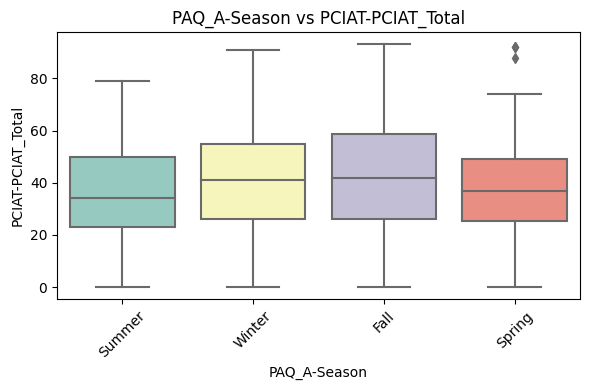

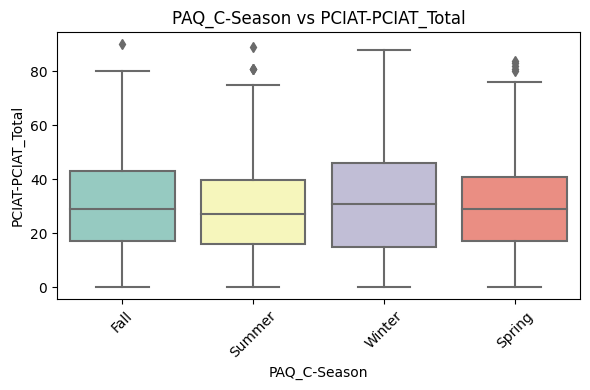

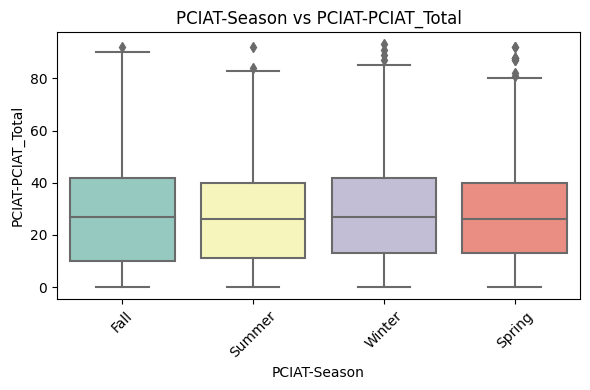

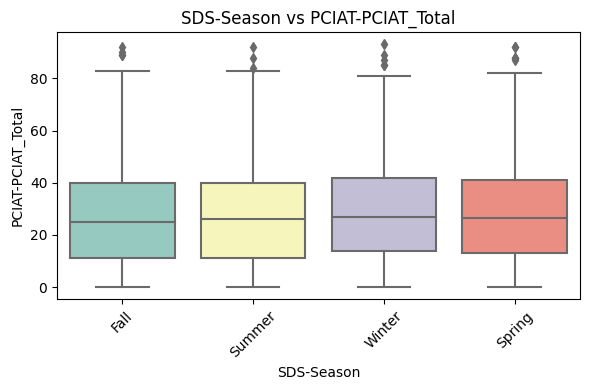

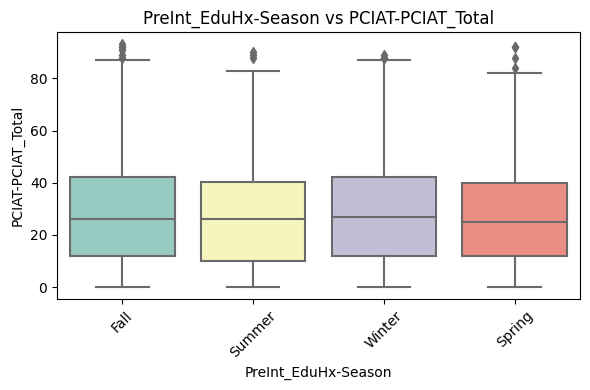

In [8]:
# Select categorical columns (object or category types)
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", cat_cols)

# Count plots
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=train[col], palette="Set2")
    plt.title(f"Count Plot of {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Box plots against target
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=col, y='PCIAT-PCIAT_Total', data=train, palette="Set3")
    plt.title(f"{col} vs PCIAT-PCIAT_Total")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [9]:
# =============================================================================
# CONSTANTS
# =============================================================================
TARGET_sii = 'sii'
TARGET_PC = 'PCIAT-PCIAT_Total'
TARGET_binned = 'binned'
TARGET_cols = [TARGET_sii, TARGET_binned, TARGET_PC]

THRESHOLD = [31, 50, 80]
# Normalized thresholds for the “binned” version of PCIAT_Total
THRESHOLD_1 = [31*9/93, 50*9/93, 80*9/93]

In [10]:
# Create the 'binned' column based on thresholds
def apply_binning(val):
    if val < THRESHOLD[0]:
        return "Low"
    elif val < THRESHOLD[1]:
        return "Moderate"
    elif val < THRESHOLD[2]:
        return "Problematic"
    else:
        return "Severe"

train['binned'] = train['PCIAT-PCIAT_Total'].apply(apply_binning)

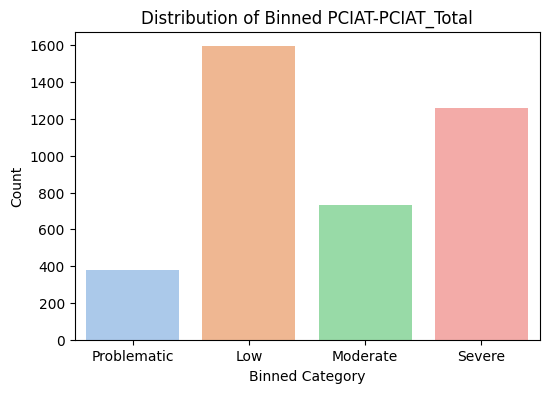

In [11]:
# Countplot of binned target
plt.figure(figsize=(6, 4))
sns.countplot(x='binned', data=train, palette="pastel")
plt.title("Distribution of Binned PCIAT-PCIAT_Total")
plt.xlabel("Binned Category")
plt.ylabel("Count")
plt.show()

In [12]:
# Identify numeric and categorical columns
all_cols = train.columns.to_list()
feature_cols = [
    col for col in all_cols
    if ('PCIAT' not in col) and (col not in ['sii', 'id', 'binned'])
]
num_cols = train[feature_cols].select_dtypes(['number']).columns.to_list()
cat_cols = [col for col in feature_cols if 'Season' in col]

# Convert seasonal columns to numeric categories
train[cat_cols] = train[cat_cols].replace({'Spring':1,'Summer':2,'Fall':3,'Winter':4})
test[cat_cols] = test[cat_cols].replace({'Spring':1,'Summer':2,'Fall':3,'Winter':4})

train[cat_cols] = train[cat_cols].fillna(0).astype('int').astype('category')
test[cat_cols] = test[cat_cols].fillna(0).astype('int').astype('category')

In [13]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

# =============================================================================
# DATA ENCODING & SCALING FUNCTIONS
# =============================================================================
def label_encode(df_train, df_test, cols):
    train_le = df_train.copy()
    test_le = df_test.copy()
    cardinality = {}
    encoder = {}
    for col in cols:
        le = LabelEncoder()
        train_le[col] = train_le[col].astype(str)
        test_le[col] = test_le[col].astype(str)
        le.fit(train_le[col])
        train_le[col] = le.transform(train_le[col])
        # handle unknowns gracefully in test set
        test_le[col] = test_le[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        cardinality[col] = len(le.classes_)
        encoder[col] = le
    return train_le, test_le, cardinality, encoder

def scaler_encode(df_train, df_test, cols):
    tr = df_train.copy()
    ts = df_test.copy()
    scaler = StandardScaler()
    tr[cols] = scaler.fit_transform(tr[cols])
    ts[cols] = scaler.transform(ts[cols])
    return tr, ts

def one_hot_encode(df_train, df_test, cols):
    df_oh = df_train.copy()
    ts_oh = df_test.copy()
    bin_cols = []
    for col in cols:
        ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')  # <- fixed for Kaggle
        temp_df = ohe.fit_transform(df_oh[[col]])
        temp_ts = ohe.transform(ts_oh[[col]])
        feature_names = [f"{col}_{category}" for category in ohe.categories_[0]]
        enc_df = pd.DataFrame(temp_df, columns=feature_names, index=df_oh.index)
        enc_ts = pd.DataFrame(temp_ts, columns=feature_names, index=ts_oh.index)
        df_oh = pd.concat([enc_df, df_oh], axis=1).drop(columns=[col])
        ts_oh = pd.concat([enc_ts, ts_oh], axis=1).drop(columns=[col])      
        bin_cols.extend(feature_names)
    return df_oh, ts_oh, bin_cols

In [14]:
# =============================================================================
# PARQUET READING & PROCESSING FOR TIME SERIES
# =============================================================================
'''
Below, we read multiple parquet files. We first figure out the variance of time series columns
then pick those with higher variance to train KMeans. We cluster new data using that model.
'''


def process_file_whole(filename, dirname):
    """
    Reads a parquet file, removes null values, 
    and returns time series variance and other stats in a dict.
    """
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)

    # For collection == 0: gather stats
    if collection == 0:
        df.dropna(inplace=True)
        n_ts = {
            'size': len(df),
            'var': df['X'].var() + df['Y'].var() + df['Z'].var() + df['enmo'].var(),
            'non_wear': df['non-wear_flag'].sum(),
            'id': filename.split('=')[1]
        }
        return n_ts
    
    # For collection == 1: read raw data
    if collection == 1:
        return df

def load_time_series_whole(dirname):
    """
    If collection == 0, returns a dataframe of variance stats from all IDs.
    If collection == 1, merges the selected IDs (id_call) data.
    """
    ids = os.listdir(dirname)

    if collection == 0:
        with ThreadPoolExecutor() as executor:
            results = list(tqdm(executor.map(
                lambda fname: process_file_whole(fname, dirname), 
                ids), total=len(ids))
            )
        return pd.DataFrame(results)

    elif collection == 1:
        data_id = []
        for id_ in id_call:
            data_id.append(process_file_whole('id='+id_, dirname))
        return pd.concat(data_id, ignore_index=True)

# First pass: figure out variance
collection = 0
pr_data = load_time_series_whole("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
pr_data = pd.merge(pr_data, train[['sii','id']], how='left', on='id')
pr_data['non-wear_size'] = pr_data['non_wear'] / pr_data['size']

# Pick top variance from each SII=0..3
id_call = []
for j in range(4):
    index_var = pr_data[pr_data['sii'] == j]['var'].nlargest(3).index
    id_call.extend(pr_data.loc[index_var]['id'].values)

# Second pass: read in those high variance files
collection = 1
prq_train = load_time_series_whole("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")

# =============================================================================
# KMeans CLUSTERING
# =============================================================================
# Prepare data for clustering
prq_train['time-diff'] = (
    prq_train['time_of_day'] - prq_train['time_of_day'].shift(1)
).where(
    prq_train['relative_date_PCIAT'] == prq_train['relative_date_PCIAT'].shift(1), 
    0
)

movment_cols = ['X','Y','Z','enmo','anglez','light','time-diff']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(prq_train[movment_cols])

k = 15
kmeans = KMeans(n_clusters=k, random_state=RND_SEED)
kmeans.fit(X_scaled)

100%|██████████| 996/996 [00:32<00:00, 30.50it/s]


KMeans(n_clusters=15, random_state=42)

In [15]:
def extract_movment(parquet_data):
    """
    Applies the trained KMeans model on a parquet dataframe,
    returns the proportion of each cluster's 'time-diff' sum to the entire 'time-diff'.
    """
    pq = parquet_data.copy()
    pq['time-diff'] = (
        pq['time_of_day'] - pq['time_of_day'].shift(1)
    ).where(
        pq['relative_date_PCIAT'] == pq['relative_date_PCIAT'].shift(1),
        0
    )
    X = StandardScaler().fit_transform(pq[movment_cols])
    clusters = kmeans.predict(X)
    pq['cluster'] = clusters

    mov = {}
    for i in range(k):
        cluster_df = pq[pq['cluster'] == i]
        # Ratio of that cluster’s time-diff sum to the entire time-diff sum
        mov[f'movement_{i+1}_mean'] = cluster_df['time-diff'].sum() / pq['time-diff'].sum()
    return mov

In [16]:
def process_file(filename, dirname):
    """
    Reads a parquet file, 
    extracts movement clusters with extract_movment().
    """
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    df.dropna(inplace=True)
    n_ts = extract_movment(df)
    n_ts['id'] = filename.split('=')[1]
    return n_ts

def load_time_series(dirname):
    """
    Loads all parquet files in a folder, 
    extracts cluster-based movement features for each, 
    and returns them in a dataframe.
    """
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(
            lambda fname: process_file(fname, dirname),
            ids), total=len(ids))
        )
    return pd.DataFrame(results)

# Load and merge with train/test data
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

train_ts.fillna(0, inplace=True)
test_ts.fillna(0, inplace=True)
train_ts = pd.merge(train, train_ts, how="left", on='id')
test_ts = pd.merge(test, test_ts, how="left", on='id')

# Time-series feature columns
ts_cols = [col for col in train_ts.columns if 'movement' in col]
num_cols_ts = num_cols + ts_cols
feature_cols_ts = feature_cols + ts_cols

100%|██████████| 2/2 [00:00<00:00,  6.93it/s]


In [17]:
# =============================================================================
# CASTING CATEGORICAL & IMPUTATION
# =============================================================================
train[cat_cols] = train[cat_cols].astype('int').astype('category')
test[cat_cols] = test[cat_cols].astype('int').astype('category')

# Impute numeric features with KNN
imputer = KNNImputer(n_neighbors=10)
train_imputed = imputer.fit_transform(train[num_cols])
test_imputed = imputer.transform(test[num_cols])

train[num_cols] = pd.DataFrame(train_imputed, columns=num_cols)
test[num_cols] = pd.DataFrame(test_imputed, columns=num_cols)

# Impute numeric features for TS-extended data
imputer_ts = KNNImputer(n_neighbors=10)
train_imputed_ts = imputer_ts.fit_transform(train_ts[num_cols_ts])
test_imputed_ts = imputer_ts.transform(test_ts[num_cols_ts])

train_ts[num_cols_ts] = pd.DataFrame(train_imputed_ts, columns=num_cols_ts)
test_ts[num_cols_ts] = pd.DataFrame(test_imputed_ts, columns=num_cols_ts)

In [18]:
# =============================================================================
# SPLIT TRAIN INTO LABELED & UNLABELED
# =============================================================================
train_missing = train[train[TARGET_sii].isna()].copy().reset_index(drop=True)
train_ts = train_ts.dropna(subset=[TARGET_sii]).reset_index(drop=True)
train = train.dropna(subset=[TARGET_sii]).reset_index(drop=True)

# Create “binned” column for the train
train[TARGET_binned] = pd.cut(train[TARGET_PC], bins=10, labels=False)

In [19]:
# =============================================================================
# STEP 1: MODELING DATASET SETUP (AFTER SPLIT)
# =============================================================================
X_train = train_ts[feature_cols_ts].copy()
X_test = test_ts[feature_cols_ts].copy()
y_train = train['PCIAT-PCIAT_Total'].copy()

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (2736, 73)
X_test shape: (20, 73)
y_train shape: (2736,)


In [20]:
# using sample weight idea from :https://www.kaggle.com/code/lennarthaupts/cmi-detecting-problematic-digital-behavior.
def label_weight(data):
    bins = pd.cut(data, bins=10, labels=False)
    bin_counts = bins.value_counts(normalize=True)
    weight_map = (1 / bin_counts).to_dict()
    weights = bins.map(weight_map)
    return weights / weights.mean()

In [21]:
# =============================================================================
# STEP 2: K-FOLD CROSS-VALIDATION SETUP
# =============================================================================
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=RND_SEED)

oof_preds = np.zeros(len(X_train))
test_preds = np.zeros(len(X_test))
fold_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n--- Fold {fold+1} ---")
    
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        random_state=RND_SEED
    )
    
    model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)]
    )

    
    oof_preds[val_idx] = model.predict(X_val)
    test_preds += model.predict(X_test) / n_splits
    score = mean_squared_error(y_val, oof_preds[val_idx], squared=False)
    fold_scores.append(score)
    print(f"Fold {fold+1} RMSE: {score:.4f}")

# Overall CV RMSE
print(f"\nAverage CV RMSE: {np.mean(fold_scores):.4f}")


--- Fold 1 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10990
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 73
[LightGBM] [Info] Start training from score 28.187386
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 17.8501	valid_0's l2: 318.625
Early stopping, best iteration is:
[85]	valid_0's rmse: 17.7704	valid_0's l2: 315.788
Fold 1 RMSE: 17.7704

--- Fold 2 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10993
[LightGBM] [Info] Number of data points in the train set: 2189, number of used features: 73
[LightGBM] [Info] Start training from score 28.32160

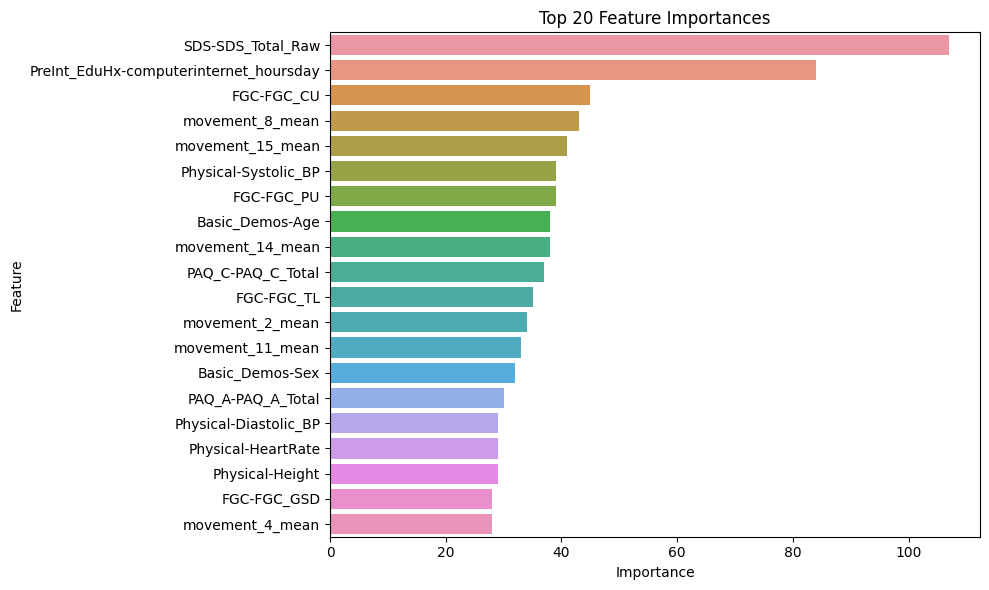

,Feature,Importance
54,SDS-SDS_Total_Raw,107
57,PreInt_EduHx-computerinternet_hoursday,84
18,FGC-FGC_CU,45
65,movement_8_mean,43
72,movement_15_mean,41
12,Physical-Systolic_BP,39
24,FGC-FGC_PU,39
1,Basic_Demos-Age,38
71,movement_14_mean,38
52,PAQ_C-PAQ_C_Total,37


In [22]:
# =============================================================================
# STEP 3: FEATURE IMPORTANCE FROM FINAL MODEL
# =============================================================================
importances = model.feature_importances_
feat_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_importance.head(20), x='Importance', y='Feature')
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

# Display table of top 20
display(feat_importance.head(20))


In [23]:
# =============================================================================
# STEP 4: PREPARE SUBMISSION
# =============================================================================
submission = sample.copy()
submission['PCIAT-PCIAT_Total'] = test_preds
submission.to_csv("submission.csv", index=False)

print("Submission file created: submission.csv")
display(submission.head())

Submission file created: submission.csv


,id,sii,PCIAT-PCIAT_Total
0,00008ff9,0,30.600768
1,000fd460,1,11.464040
2,00105258,2,30.135775
3,00115b9f,3,26.456422
4,0016bb22,0,40.145888


In [24]:
def quadratic_weighted_kappa(target, preds):
    return cohen_kappa_score(target, preds, weights="quadratic")

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
           np.where(oof_non_rounded < thresholds[1], 1,
           np.where(oof_non_rounded < thresholds[2], 2, 3)))

def multiple_rmse_scores(actual, predicted):
    errors = []
    for i in range(predicted.shape[1]):
        errors.append(mean_squared_error(actual, predicted[:, i]))
    return errors


In [25]:
# =============================================================================
# STEP 5: PREDICTING SII VIA REGRESSION + THRESHOLDING
# =============================================================================
y_train_sii = train[TARGET_sii].astype(int)

kf = KFold(n_splits=5, shuffle=True, random_state=RND_SEED)

oof_preds_sii = np.zeros(len(X_train))
test_preds_sii = np.zeros(len(X_test))
fold_kappas = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n--- Fold {fold+1} for SII ---")
    
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train_sii.iloc[train_idx], y_train_sii.iloc[val_idx]
    
    model = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        random_state=RND_SEED
    )
    
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ]
    )
    
    oof_preds_sii[val_idx] = model.predict(X_val)
    test_preds_sii += model.predict(X_test) / kf.n_splits

# Use static thresholds from competition
static_thresholds = [0.5, 1.5, 2.5]
rounded_preds = threshold_Rounder(oof_preds_sii, static_thresholds)
kappa = quadratic_weighted_kappa(y_train_sii, rounded_preds)

print(f"\nQuadratic Weighted Kappa: {kappa:.4f}")



--- Fold 1 for SII ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10990
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 73
[LightGBM] [Info] Start training from score 0.587751
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.674252	valid_0's l2: 0.454616
Early stopping, best iteration is:
[75]	valid_0's rmse: 0.672259	valid_0's l2: 0.451933

--- Fold 2 for SII ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10993
[LightGBM] [Info] Number of data points in the train set: 2189, number of used features: 73
[LightGBM] [Info] Start training from score 0.596619
Training until validation scores don't improve for 50 rounds
Earl

In [26]:
# =============================================================================
# MODEL INIT CLASS
# =============================================================================
'''
This class performs cross-validation training for different models 
and returns out-of-fold predictions (oof) plus test predictions.
'''
class model_init:
    def __init__(self, model_class, params):
        self.model_class = model_class
        self.model_params = params
    
    def model_build(self):
        """
        Builds a fresh model from the class and params given.
        If it's a Keras model, we handle it differently.
        """
        if (self.model_class != keras_model):
            self.model = self.model_class(**self.model_params)
        else:
            self.model = self.model_class()
    
    def Train(self, df_train, df_test, final_target, n_split):
        """
        Manages cross-validation for the specified model.
        Returns OOF predictions, test predictions, overall QWK, and the model itself.
        """
        if 'original' in df_train.columns:
            self.train = df_train[df_train['original'] == 1].drop('original', axis=1).reset_index(drop=True)
            self.plus = df_train[df_train['original'] == 0].drop('original', axis=1).reset_index(drop=True)
        else:
            self.train = df_train
            self.plus = None
        
        self.test = df_test
        self.target_col = final_target
        self.n_split = n_split

        return self.fit_cv()
    
    def fit(self, X_train, y_train, X_val, y_val):
        """
        Fits a single fold of data.
        Uses sample weighting for certain runs.
        """
        if WH == 1:
            weights = label_weight(y_train)
        else:
            weights = np.ones(len(y_train))

        # Keras model
        if isinstance(self.model, keras_model):
            self.model = build_nn_model()  # builds the structure
            self.model.compile(
                optimizer=keras.optimizers.AdamW(
                    learning_rate=learning_rate,
                    weight_decay=0.01,
                    beta_1=0.9,
                    beta_2=0.999,
                    epsilon=1e-07
                ),
                loss='mse',
                metrics=['mse']
            )
            self.model.fit(
                nn_enc(X_train),
                y_train,
                batch_size=BS,
                epochs=epochs,
                sample_weight=weights,
                validation_data=(nn_enc(X_val), y_val),
                verbose=0
            )
        else:
            # Classic ML
            self.model.fit(X_train, y_train, sample_weight=weights)

    def predict(self, X):
        """
        Predict either with a Keras model or a scikit-learn model.
        """
        if isinstance(self.model, keras_model):
            return self.model.predict(nn_enc(X), verbose=0, batch_size=BS).flatten()
        else:
            return self.model.predict(X)

    def fit_cv(self):
        """
        K-fold cross-validation: returns OOF predictions, test predictions, QWK, and model list.
        """
        oof_pred = np.zeros(len(self.train))
        test_pred = np.zeros(len(self.test))

        kfold = StratifiedKFold(
            n_splits=self.n_split, shuffle=True, random_state=RND_SEED
        )

        for folds, (idx_train, idx_val) in enumerate(
            kfold.split(self.train, self.train[TARGET_sii])
        ):
            model_fold = []

            if self.plus is None:
                tr = self.train.loc[idx_train]
            else:
                tr = pd.concat(
                    [self.train.loc[idx_train], self.plus],
                    ignore_index=True
                )
            
            X_train = tr.drop(TARGET_cols, axis=1)
            y_train = tr[self.target_col]
            X_val = self.train.loc[idx_val].drop(TARGET_cols, axis=1)
            y_val = self.train.loc[idx_val][TARGET_sii]

            self.model_build()
            self.fit(X_train, y_train, X_val, y_val)
            oof_pred[idx_val] = self.predict(X_val)
            test_pred += self.predict(self.test) / self.n_split

            # Round OOF predictions using threshold
            rounded_oof_fold = threshold_Rounder(oof_pred[idx_val], THRESHOLD_1)
            fold_scores_qwk = quadratic_weighted_kappa(y_val, rounded_oof_fold)
            print(f"\nFold No:{folds+1} QWK_metrics : {fold_scores_qwk:.5f}")

            model_fold.append(self.model)

        # Evaluate overall metrics
        rounded_oof = threshold_Rounder(oof_pred, THRESHOLD_1)
        overal_score = quadratic_weighted_kappa(self.train[TARGET_sii], rounded_oof)
        overal_score_rmse = mean_squared_error(self.train[self.target_col], oof_pred)
        print(f"\n-------Overall QWK Score: {overal_score:.5f}")
        print(f"-------Overall rsme Score: {overal_score_rmse:.5f}\n")

        return oof_pred, test_pred, overal_score, model_fold

In [27]:
# =============================================================================
# NEURAL NETWORK UTILS
# =============================================================================
def build_nn_model():
    """
    Builds a base Keras model with embeddings for categorical features.
    """
    if nn_model_type == 'base model':
        input_categorical = []
        embedding_layers = []

        # Numeric inputs
        cont_inputs = Input(shape=(len(num_cols_nn),))
        keras.utils.set_random_seed(RND_SEED)

        # Categorical embeddings
        for col in cat_cols:
            input_cat = Input(shape=(1,))
            card = cat_card[col]
            embed_dim = min(8, card // 2)  # rule of thumb
            embedding = Embedding(input_dim=card, output_dim=embed_dim)(input_cat)
            embedding = Flatten()(embedding)
            input_categorical.append(input_cat)
            embedding_layers.append(embedding)

        # Combine all features
        all_features = Concatenate()(
            embedding_layers + [cont_inputs]
        )

        # Dense layers
        nn_layer = Dense(256, activation='relu')(all_features)
        nn_layer = Dropout(0.2, seed=RND_SEED)(nn_layer)
        nn_layer = Dense(128, activation='relu')(nn_layer)
        nn_layer = Dropout(0.2, seed=RND_SEED)(nn_layer)
        nn_layer = Dense(64, activation='relu')(nn_layer)

        # Final output
        output = Dense(1)(nn_layer)
        model = Model(inputs=[cont_inputs] + input_categorical, outputs=output)
        return model

def nn_enc(df):
    """
    Transforms the dataset into the input format expected by the base Keras model.
    Returns a list: [numerical_cols] + [cat_col1, cat_col2, ...]
    """
    return [df[num_cols_nn].values] + [df[col].values for col in cat_cols]


In [28]:
# =============================================================================
# HILL CLIMBING FOR ENSEMBLING
# =============================================================================
class hill_climbing:
    """
    Performs a hill-climbing approach to ensemble multiple model predictions 
    by searching for the best linear combination that lowers RMSE.
    """

    def __init__(self, eval_metric, tol=1e-9, max_model=1000):
        self.max_model = max_model
        self.tol = tol
        self.metric = eval_metric

    def fit(self, train, target, score):
        """
        Train: data frame with out-of-fold model predictions as columns
        Target: real labels
        Score: current best score
        """
        best_score = 0
        best_index = -1
        indices = [best_index]
        old_best_score = best_score
        self.train = np.array(train)
        self.target = np.array(target.values)

        # Weight steps
        start = -0.50
        ww = np.arange(start, 0.51, 0.01)
        nn = len(ww)
        files = train.keys().to_list()

        self.models = [best_index]
        self.weights = []
        metrics = [best_score]

        # The final ensemble after each addition
        best_ensemble = self.train[:, best_index]

        for kk in range(10000):
            best_score = score
            best_index = -1
            best_weight = 0

            # Try adding each model and check improvement
            for k, ff in enumerate(files):
                new_model = self.train[:, k]  
                m1 = np.repeat(best_ensemble[:, np.newaxis], nn, axis=1) * (1 - ww)
                m2 = np.repeat(new_model[:, np.newaxis], nn, axis=1) * ww
                mm = m1 + m2
                new_rmse = self.metric(self.target, mm)
                new_score = np.min(new_rmse).item()

                if new_score < best_score:
                    best_score = new_score
                    best_index = k
                    ii = np.argmin(new_rmse).item()
                    best_weight = ww[ii].item()
                    potential_ensemble = mm[:, ii]

            # STOP CRITERIA
            indices.append(best_index)
            indices = list(np.unique(indices))
            if len(indices) > self.max_model:
                print(f'=> Reached {self.max_model} models')
                indices = indices[:-1]
                break
            if abs(best_score - old_best_score) < self.tol:
                print(f'=> Reached tolerance {self.tol}')
                break

            # Record new results
            if best_index != -1:
                print(
                    kk,
                    'New best rmse', best_score,
                    f'adding "{files[best_index]}"',
                    'weight', f'{best_weight:0.3f}'
                )
                self.models.append(best_index)
                self.weights.append(best_weight)
                metrics.append(best_score)
                best_ensemble = potential_ensemble
                old_best_score = best_score

        # Combine weights
        wgt = np.array([1])
        for w in self.weights:
            wgt = wgt * (1 - w)
            wgt = np.concatenate([wgt, np.array([w])])

        # Show final model weights
        rows = []
        t = 0
        for m, w, s in zip(self.models, wgt, metrics):
            if m == -1:
                continue
            name = files[m]
            dd = {'weight': w, 'model': name}
            rows.append(dd)
            t += float(f'{w:.3f}')
        self.cl_output = pd.DataFrame(rows)
        self.cl_output = (
            self.cl_output.groupby('model')
            .agg('sum')
            .reset_index()
            .sort_values('weight', ascending=False)
            .reset_index(drop=True)
        )

    def predict(self, test):
        """
        Applies the discovered weights to the test set predictions.
        """
        self.test_final = 0
        for i, j in enumerate(self.cl_output.model):
            self.test_final += test[j] * self.cl_output.loc[i]['weight']
        return self.test_final

In [29]:
# =============================================================================
# SEMI-SUPERVISED LEARNING STEP 
# =============================================================================
'''
Below, we do a semi-supervised approach:
1) Train multiple models on labeled data
2) Use hill-climbing ensemble to label unlabeled data
3) Merge them back
4) Train again on the combined dataset
'''



train_nn = train[feature_cols].copy()
test_nn = train_missing[feature_cols].copy()
train_nn[TARGET_cols] = train[TARGET_cols]

train_nn, test_nn, cat_card, _ = label_encode(train_nn, test_nn, cat_cols)
train_nn, test_nn = scaler_encode(train_nn, test_nn, num_cols)
num_cols_nn = num_cols

# Keras model example
WH = 0
BS = 256
epochs = 6
learning_rate = 3e-3
nn_model_type = 'base model'
nn_instance = keras.Model()

model_nn = model_init(keras_model, None)
oof_nn, test_missing_nn, acc_nn, model_NN = model_nn.Train(
    train_nn, test_nn, TARGET_PC, 5
)

# CatBoost example
train_gb = train[feature_cols].copy()
test_gb = train_missing[feature_cols].copy()
train_gb[TARGET_cols] = train[TARGET_cols]

param_cat = {
    'objective': 'Tweedie:variance_power=1.5', 
    'iterations': 273, 
    'depth': 6,
    'learning_rate': 0.03347776308515933,
    'l2_leaf_reg': 0.0005342937261279777, 
    'subsample': 0.645614570099021, 
    'bagging_temperature': 0.6118528947223795, 
    'random_strength': 1.3957991126597662, 
    'colsample_bylevel': 0.6460723242676091,
    'min_data_in_leaf': 37,
    'random_state': RND_SEED,
    'cat_features': cat_cols,
    'verbose': 0
}
model_cat = model_init(ctb.CatBoostRegressor, param_cat)
oof_cat, test_missing_cat, acc_cat, model_cat = model_cat.Train(
    train_gb, test_gb, TARGET_PC, n_split=5
)

# LightGBM example
param_lgb = {
    'objective': 'tweedie', 
    'n_estimators': 597, 
    'max_depth': 3, 
    'learning_rate': 0.01019160829182289,
    'subsample': 0.5261976292373335,
    'colsample_bytree': 0.5351784713007832,
    'tweedie_variance_power': 1.152466250299122,
    'random_state': RND_SEED,
    'verbosity': -1
}
model_lgb = model_init(lgb.LGBMRegressor, param_lgb)
oof_lgb, test_missing_lgb, acc_lgb, model_lgb = model_lgb.Train(
    train_gb, test_gb, TARGET_PC, n_split=5
)

# Lasso example
param_lasso = {
    'fit_intercept': True,
    'precompute': True, 
    'copy_X': True, 
    'warm_start': True,
    'selection': 'random',
    'max_iter': 531, 
    'alpha': 0.0004496880541220534, 
    'tol': 1.4872791031412706e-05,
    'random_state': RND_SEED
}
model_lasso = model_init(Lasso, param_lasso)
oof_lasso, test_missing_lasso, _, model_lasso = model_lasso.Train(
    train_gb, test_gb, TARGET_PC, n_split=5
)

# XGBoost example
param_xgb = {
    'objective': 'reg:squarederror',
    'n_estimators': 327,
    'max_depth': 3,
    'learning_rate': 0.020155904604737717,
    'subsample': 0.7712561640659066, 
    'colsample_bytree': 0.5466806743991856,
    'gamma': 2.6288923622161713,
    'reg_alpha': 9.468184374972093e-05,
    'reg_lambda': 0.0003582157866941332,
    'tweedie_variance_power': 1.1581422325461046,
    'enable_categorical': True,
    'random_state': RND_SEED,
    'verbosity': 0
}
model_xgb = model_init(xgb.XGBRegressor, param_xgb)
oof_xgb, test_missing_xgb, acc_xgb, model_xgb = model_xgb.Train(
    train_gb, test_gb, TARGET_PC, n_split=5
)

# Combine OOF predictions
oof_preds = pd.DataFrame({
    'cat': oof_cat,
    'lgb': oof_lgb,
    'xgb': oof_xgb,
    'nn': oof_nn,
    'lasso': oof_lasso
})

missing_pred = pd.DataFrame({
    'cat': test_missing_cat,
    'lgb': test_missing_lgb,
    'xgb': test_missing_xgb,
    'nn': test_missing_nn,
    'lasso': test_missing_lasso
})

# Hill climbing ensemble on unlabeled portion
hc = hill_climbing(eval_metric=multiple_rmse_scores)
hc.fit(oof_preds, train[TARGET_PC], 400)
ens_missing_pred = hc.predict(missing_pred)

# Convert predictions to integer SII classes
tuned_ens_missing = threshold_Rounder(ens_missing_pred, THRESHOLD)

# Merge back and re-train
train_missing[TARGET_sii] = tuned_ens_missing.round().astype('int')
train_missing[TARGET_PC] = ens_missing_pred
train_missing[TARGET_binned] = pd.cut(ens_missing_pred.round(), bins=10, labels=False)
train_missing['original'] = 0

train['original'] = 1
train_plus = pd.concat([train_missing, train], ignore_index=True)



Fold No:1 QWK_metrics : 0.00066

Fold No:2 QWK_metrics : 0.00084

Fold No:3 QWK_metrics : 0.00066

Fold No:4 QWK_metrics : 0.00298

Fold No:5 QWK_metrics : 0.00099

-------Overall QWK Score: 0.00123
-------Overall rsme Score: 335.14473


Fold No:1 QWK_metrics : 0.00066

Fold No:2 QWK_metrics : 0.00165

Fold No:3 QWK_metrics : 0.00000

Fold No:4 QWK_metrics : 0.00198

Fold No:5 QWK_metrics : 0.00132

-------Overall QWK Score: 0.00112
-------Overall rsme Score: 293.13753


Fold No:1 QWK_metrics : 0.00033

Fold No:2 QWK_metrics : 0.00098

Fold No:3 QWK_metrics : 0.00000

Fold No:4 QWK_metrics : 0.00165

Fold No:5 QWK_metrics : 0.00033

-------Overall QWK Score: 0.00066
-------Overall rsme Score: 296.94788


Fold No:1 QWK_metrics : 0.00467

Fold No:2 QWK_metrics : 0.00900

Fold No:3 QWK_metrics : 0.00086

Fold No:4 QWK_metrics : 0.01156

Fold No:5 QWK_metrics : 0.00140

-------Overall QWK Score: 0.00548
-------Overall rsme Score: 301.65361


Fold No:1 QWK_metrics : 0.00033

Fold No:2 QWK_

In [30]:
# =============================================================================
# FINAL VOTING EXAMPLE
# =============================================================================
'''
At the end, we do a final stage of training with multiple models 
(including time series features for some) and ensemble them via hard voting.
'''

'\nAt the end, we do a final stage of training with multiple models \n(including time series features for some) and ensemble them via hard voting.\n'

In [31]:
train_nn = train_plus.copy()
test_nn = test.copy()

train_nn,test_nn,cat_card,_ = label_encode(train_nn,test_nn, cat_cols)
train_nn,test_nn = scaler_encode(train_nn,test_nn,num_cols)
num_cols_nn = num_cols
WH = 1
BS=256
epochs = 6
learning_rate = 3e-3
nn_model_type = 'base model'
nn_instance = keras.Model()
model_nn = model_init(keras_model,None)
oof_pred_nn,test_pred_nn,acc_nn,model_NN=model_nn.Train(train_nn,test_nn,TARGET_binned,5)


Fold No:1 QWK_metrics : 0.44752

Fold No:2 QWK_metrics : 0.48311

Fold No:3 QWK_metrics : 0.47663

Fold No:4 QWK_metrics : 0.38911

Fold No:5 QWK_metrics : 0.41617

-------Overall QWK Score: 0.44244
-------Overall rsme Score: 4.57951



In [32]:
#Preparing data with and without timeseries features

train_gb_plus = train_plus[feature_cols].copy()
train_gb_plus['original'] = train_plus['original']
train_gb_plus[TARGET_cols] = train_plus[TARGET_cols]
test_gb = test[feature_cols].copy()

train_gb_ts = train_ts[feature_cols_ts].copy()
train_gb_ts[TARGET_cols] = train[TARGET_cols]
test_gb_ts = test_ts[feature_cols_ts]

In [33]:
WH = 1
train_dt,test_dt,_ = one_hot_encode(train_gb_plus,test_gb,cat_cols)
param_dt={
          'criterion': 'squared_error', 
          'splitter': 'best',
          'max_depth': 5,
          'min_samples_split': 100, 
          'min_samples_leaf': 5,
          'min_impurity_decrease': 0.02,
           'ccp_alpha': 0.01,
          'random_state' : RND_SEED,
          }

model_dt = model_init(DecisionTreeRegressor,param_dt)
oof_pred_dt_plus,test_pred_dt_plus,acc_dt,model_dt_plus=model_dt.Train(train_dt,test_dt,TARGET_binned,n_split = 5)


Fold No:1 QWK_metrics : 0.39751

Fold No:2 QWK_metrics : 0.42163

Fold No:3 QWK_metrics : 0.35021

Fold No:4 QWK_metrics : 0.36730

Fold No:5 QWK_metrics : 0.37003

-------Overall QWK Score: 0.38256
-------Overall rsme Score: 5.12529



In [34]:
train_lr = train_gb_plus.copy()
test_lr = test_gb.copy()
train_lr,test_lr = scaler_encode(train_lr,test_lr ,num_cols)
WH=0
param_lr= {
         'solver': 'newton-cg',
          'penalty':'l2',
         'class_weight' :'balanced',
         'multi_class': 'multinomial',
         'max_iter': 500,
         'warm_start': True,
        'verbose':0, 
    }
        
model_lr = model_init(LogisticRegression,param_lr)
oof_pred_lr_plus,test_pred_lr_plus,overal_score,model_lr_plus=model_lr.Train(train_lr,test_lr,TARGET_binned,n_split = 5)


Fold No:1 QWK_metrics : 0.37709

Fold No:2 QWK_metrics : 0.47051

Fold No:3 QWK_metrics : 0.39885

Fold No:4 QWK_metrics : 0.33666

Fold No:5 QWK_metrics : 0.35232

-------Overall QWK Score: 0.38755
-------Overall rsme Score: 7.02266



In [35]:
WH = 1
param_lgb={'objective': 'tweedie',
           'n_estimators': 576, 
           'max_depth': 3, 
           'learning_rate': 0.014504865871703278,
           'subsample': 0.7724866369943665, 
           'colsample_bytree': 0.5717189909747162,
           'random_state' : RND_SEED,
           'verbosity': -1,
          }

model_lgb = model_init(lgb.LGBMRegressor,param_lgb)
oof_pred_lgb_plus,test_pred_lgb_plus,acc_lgb,model_lgb_plus=model_lgb.Train(train_gb_plus,test_gb,TARGET_binned,n_split = 5)


Fold No:1 QWK_metrics : 0.45906

Fold No:2 QWK_metrics : 0.51438

Fold No:3 QWK_metrics : 0.45610

Fold No:4 QWK_metrics : 0.43294

Fold No:5 QWK_metrics : 0.42868

-------Overall QWK Score: 0.45812
-------Overall rsme Score: 3.90348



In [36]:
WH = 1
param_cat={'objective': 'Tweedie:variance_power=1.5',
           'iterations': 292,
           'depth': 6,
           'learning_rate': 0.0624982363237828, 
           'l2_leaf_reg': 0.019685934698040447, 
           'subsample': 0.5018495996455012,
           'bagging_temperature': 0.8627252427715155,
           'random_strength': 5.015068697208244, 
           'colsample_bylevel': 0.6124379138359408,
           'min_data_in_leaf': 89,
           'random_state': RND_SEED,
            'cat_features' : cat_cols,
            'verbose': 0
            }

model_cat = model_init(ctb.CatBoostRegressor,param_cat)
oof_pred_cat_plus,test_pred_cat_plus,acc_cat,model_cat_plus=model_cat.Train(train_gb_plus,test_gb,TARGET_binned,n_split = 5)


Fold No:1 QWK_metrics : 0.45287

Fold No:2 QWK_metrics : 0.50194

Fold No:3 QWK_metrics : 0.44866

Fold No:4 QWK_metrics : 0.42877

Fold No:5 QWK_metrics : 0.42615

-------Overall QWK Score: 0.45212
-------Overall rsme Score: 3.66338



In [37]:
WH = 1
param_lgb={'iterations': 1000,
             'objective':'tweedie',
            'max_depth': 10,
            # # 'cat_features' : cat_cols,
            'learning_rate': 0.04,
            # 'bagging_fraction': 0.78,
            # 'bagging_freq' : 20,
            #  # 'border_count': 60,
             'verbosity' : -1}

model_lgb = model_init(lgb.LGBMRegressor,param_lgb)
oof_pred_lgb_ts,test_pred_lgb_ts,acc_lgb,model_lgb_ts=model_lgb.Train(train_gb_ts,test_gb_ts,TARGET_binned,n_split = 5)


Fold No:1 QWK_metrics : 0.45204

Fold No:2 QWK_metrics : 0.50667

Fold No:3 QWK_metrics : 0.41678

Fold No:4 QWK_metrics : 0.42311

Fold No:5 QWK_metrics : 0.39875

-------Overall QWK Score: 0.43942
-------Overall rsme Score: 3.55387



In [38]:
WH = 1
param_cat={'iterations': 500,
            'depth': 6,
            'learning_rate': 0.015,
            'l2_leaf_reg': 0.002,
            'random_strength': 0.46,
            'cat_features' : cat_cols,
            # 'border_count': 51,
            # 'min_data_in_leaf': 13,
            'verbose' : 0}
model_cat = model_init(ctb.CatBoostRegressor,param_cat)
oof_pred_cat_ts,test_pred_cat_ts,acc_cat,model_cat=model_cat.Train(train_gb_ts,test_gb_ts,TARGET_binned,n_split = 5)


Fold No:1 QWK_metrics : 0.43408

Fold No:2 QWK_metrics : 0.50517

Fold No:3 QWK_metrics : 0.45858

Fold No:4 QWK_metrics : 0.41259

Fold No:5 QWK_metrics : 0.42637

-------Overall QWK Score: 0.44702
-------Overall rsme Score: 3.74436



In [39]:
WH = 1
param_xgb={'objective': 'reg:tweedie',
           'n_estimators': 480,
           'max_depth': 3, 
           'learning_rate': 0.025707833957860277,
           'subsample': 0.5290418060840998,
           'colsample_bytree': 0.9330880728874675,
           'gamma': 3.005575058716044,
           'reg_alpha': 0.006796578090758156,
           'reg_lambda': 1.2087541473056957e-05,
           'tweedie_variance_power': 1.9699098521619942,
           'random_state' : RND_SEED,
           'enable_categorical' : True,
            'verbosity' : 0}

model_xgb = model_init(xgb.XGBRegressor,param_xgb)
oof_pred_xgb_plus,test_pred_xgb_plus,acc_xgb,model_xgb_plus=model_xgb.Train(train_gb_plus,test_gb,TARGET_binned,n_split = 5)


Fold No:1 QWK_metrics : 0.46924

Fold No:2 QWK_metrics : 0.52546

Fold No:3 QWK_metrics : 0.45183

Fold No:4 QWK_metrics : 0.40068

Fold No:5 QWK_metrics : 0.42102

-------Overall QWK Score: 0.45419
-------Overall rsme Score: 4.15862



In [40]:
WH = 1
param_xgb={'iterations': 500,
            'max_depth': 3,
            'eta': 0.054,
           'objective' : 'reg:tweedie',
           'tweedie_variance_power':1.3,
            'bagging_fraction': 0.8,
           'enable_categorical' : True,
            # 'bagging_freq' : 10,
            # 'random_strength': 0.5482698471489474,
             'border_count': 48,
           'random_seed' : 4,
            'verbosity' : 0}

model_xgb = model_init(xgb.XGBRegressor,param_xgb)
oof_pred_xgb_ts,test_pred_xgb_ts,acc_xgb,model_xgb_ts=model_xgb.Train(train_gb_ts,test_gb_ts,TARGET_binned,n_split = 5)


Fold No:1 QWK_metrics : 0.46568

Fold No:2 QWK_metrics : 0.52925

Fold No:3 QWK_metrics : 0.44005

Fold No:4 QWK_metrics : 0.40162

Fold No:5 QWK_metrics : 0.37591

-------Overall QWK Score: 0.44271
-------Overall rsme Score: 4.12680



In [41]:
WH = 1
param_lasso = { 'fit_intercept': False,
               'precompute': True,
               'copy_X': False,
               'warm_start': False,
               'selection': 'cyclic',
               'max_iter': 1022,
               'alpha': 0.0005076318790591836, 
               'tol': 8.154903080917285e-05,
               'random_state' : RND_SEED

              }

model_lasso = model_init(Lasso,param_lasso)
oof_pred_lasso,test_pred_lasso,acc_lgb,model_lasso=model_lasso.Train(train_gb_plus,test_gb,TARGET_binned,n_split = 5)


Fold No:1 QWK_metrics : 0.42532

Fold No:2 QWK_metrics : 0.52225

Fold No:3 QWK_metrics : 0.41130

Fold No:4 QWK_metrics : 0.38768

Fold No:5 QWK_metrics : 0.39753

-------Overall QWK Score: 0.42859
-------Overall rsme Score: 4.69182



In [42]:
ens_preds = pd.DataFrame()
test_preds = pd.DataFrame()

# Example collection of out-of-fold predictions
ens_preds['cat_plus'] = oof_pred_cat_plus
ens_preds['cat_ts'] = oof_pred_cat_ts
ens_preds['lgb_plus'] = oof_pred_lgb_plus
ens_preds['lgb_ts'] = oof_pred_lgb_ts
ens_preds['xgb_plus'] = oof_pred_xgb_plus
ens_preds['xgb_ts'] = oof_pred_xgb_ts
ens_preds['nn'] = oof_pred_nn
ens_preds['lasso'] = oof_pred_lasso
ens_preds['dt_plus'] = oof_pred_dt_plus
ens_preds['lr_plus'] = oof_pred_lr_plus

test_preds['cat_plus'] = test_pred_cat_plus
test_preds['cat_ts'] = test_pred_cat_ts
test_preds['lgb_plus'] = test_pred_lgb_plus
test_preds['lgb_ts'] = test_pred_lgb_ts
test_preds['xgb_plus'] = test_pred_xgb_plus
test_preds['xgb_ts'] = test_pred_xgb_ts
test_preds['nn'] = test_pred_nn
test_preds['lasso'] = test_pred_lasso
test_preds['dt_plus'] = test_pred_dt_plus
test_preds['lr_plus'] = test_pred_lr_plus

# Threshold them
tuned_ens_preds = pd.DataFrame()
tuned_test_preds = pd.DataFrame()

for col in ens_preds.keys():
    tuned_ens_preds[col] = threshold_Rounder(ens_preds[col], THRESHOLD_1)
    tuned_test_preds[col] = threshold_Rounder(test_preds[col], THRESHOLD_1)

# Hard-voting (mode) ensemble
voted_oof = tuned_ens_preds.mode(axis=1).iloc[:, 0]
final_test = tuned_test_preds.mode(axis=1).iloc[:, 0]

# QWK
kappa_score = cohen_kappa_score(train[TARGET_sii], voted_oof, weights='quadratic')
print(kappa_score)

# Make final submission
submission = pd.DataFrame({
    'id': sample['id'],
    'sii': final_test
})
submission.to_csv('submission.csv', index=False)

0.4602993368845225


In [43]:
# =============================================================================
# FINAL VOTING ENSEMBLE ON SII (TRAIN_PLUS)
# =============================================================================

# Prepare features and targets
X_final = train_plus[feature_cols].copy()
y_final = train_plus[TARGET_sii].astype(int)

# Label encode + scale
X_final, test_final, cat_card, _ = label_encode(X_final, test[feature_cols].copy(), cat_cols)
X_final, test_final = scaler_encode(X_final, test_final, num_cols)

# Initialize and train models
models = {
    'lgb': lgb.LGBMClassifier(n_estimators=500, random_state=RND_SEED),
    'xgb': xgb.XGBClassifier(n_estimators=500, random_state=RND_SEED, enable_categorical=True, verbosity=0),
    'cat': ctb.CatBoostClassifier(iterations=300, verbose=0, random_state=RND_SEED)
}

preds = []

for name, clf in models.items():
    print(f"Training {name.upper()}")
    clf.fit(X_final, y_final)
    pred = clf.predict(test_final)
    if hasattr(pred, "shape") and len(pred.shape) > 1:
        pred = pred.ravel()
    preds.append(pred.astype(int))

# Majority voting
voted_preds = np.round(np.mean(preds, axis=0)).astype(int)

Training LGB
Training XGB
Training CAT


In [44]:
# =============================================================================
# FINAL SII SUBMISSION
# =============================================================================
submission = sample.copy()
submission['sii'] = voted_preds
submission.to_csv("submission_sii.csv", index=False)

print("Submission file created: submission_sii.csv")
display(submission.head(20))


Submission file created: submission_sii.csv


,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,1
4,0016bb22,0
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,0
9,0083e397,0
